## Description:

Compare OTUs that vary in rhizosphere and vary in bare soil by date and test for correlation


# Setting variables

In [1]:
workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/'
#using physeq file with sparsity of greater than 3 in 3 samples
physeqFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3'

# Init

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
# The required package list:
reqpkg = c("plyr","BiocParallel","doParallel", "DESeq2", "foreach", "ggplot2", 
   "gridExtra","scales", "metagenomeSeq", "phyloseq", "dplyr", "tidyr", 
           "reshape", "vegan")
# Load all required packages and show version
for (i in reqpkg) {
    print(i)
    print(packageVersion(i))
    suppressMessages(library(i, quietly = TRUE, verbose = FALSE, 
                             warn.conflicts = FALSE, character.only = TRUE))
}

[1] "plyr"
[1] ‘1.8.3’
[1] "BiocParallel"
[1] ‘1.0.3’
[1] "doParallel"
[1] ‘1.0.10’
[1] "DESeq2"
[1] ‘1.6.3’
[1] "foreach"
[1] ‘1.4.3’
[1] "ggplot2"
[1] ‘2.0.0’
[1] "gridExtra"
[1] ‘2.0.0’
[1] "scales"
[1] ‘0.3.0’
[1] "metagenomeSeq"
[1] ‘1.11.10’
[1] "phyloseq"
[1] ‘1.10.0’
[1] "dplyr"
[1] ‘0.4.3’
[1] "tidyr"
[1] ‘0.4.1’
[1] "reshape"
[1] ‘0.8.5’
[1] "vegan"
[1] ‘2.3.3’


In [4]:
%%R
register(MulticoreParam(20))

# Loading phyloseq object

In [5]:
%%R -i physeqFile

physeq.Full = readRDS(physeqFile)
physeq.Full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 238 samples ]
sample_data() Sample Data:       [ 238 samples by 49 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


In [6]:
%%R

#re-order levels 
sample_data(physeq.Full)$Plant = relevel(sample_data(physeq.Full)$Plant, "BARE")

#Set DAP as factor
sample_data(physeq.Full)$DAP = factor(sample_data(physeq.Full)$DAP) 
sample_data(physeq.Full)$Rep = factor(sample_data(physeq.Full)$Rep) 
sample_data(physeq.Full)$DAP %>% levels %>% print

#sample_data(physeq.Full)$PlantRep = interaction(sample_data(physeq.Full)$Rep, sample_data(physeq.Full)$Plant)


[1] "36" "53" "57" "61" "72" "79" "84" "88"


In [7]:
%%R
## Create phyloseq object on subset of samples
physeq.plant = subset_samples(physeq.Full, Plant != "BARE")
sample_data(physeq.plant)$PlantRep = interaction(sample_data(physeq.plant)$Rep, sample_data(physeq.plant)$Plant)

In [8]:
%%R
physeq.bare = subset_samples(physeq.Full, Plant == "BARE")
sample_data(physeq.bare)$DAPRep = interaction(sample_data(physeq.bare)$Rep, sample_data(physeq.bare)$DAP)
physeq.bare

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 64 samples ]
sample_data() Sample Data:       [ 64 samples by 50 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


# Create DESeq object and view results for Bare and Planted Seperately

## Test for log2fold change by date from 72 as benchmark

In [96]:
%%R
dds = phyloseq_to_deseq2(physeq.bare, ~Rep + Treatment + DAP)
d_dds = DESeq(dds, parallel = TRUE)
B.88 = results(d_dds, contrast = c("DAP", "72", "88"))
B.84 = results(d_dds, contrast = c("DAP", "72", "84"))
B.79 = results(d_dds, contrast = c("DAP", "72", "79"))
B.61 = results(d_dds, contrast = c("DAP", "72", "61"))
B.57 = results(d_dds, contrast = c("DAP", "72", "57"))
B.53 = results(d_dds, contrast = c("DAP", "72", "53"))
B.36 = results(d_dds, contrast = c("DAP", "72", "36"))


In [97]:
%%R
dds = phyloseq_to_deseq2(physeq.plant, ~Rep + Treatment + DAP)
d_dds = DESeq(dds, parallel = TRUE)
R.88 = results(d_dds, contrast = c("DAP", "72", "88"))
R.84 = results(d_dds, contrast = c("DAP", "72", "84"))
R.79 = results(d_dds, contrast = c("DAP", "72", "79"))
R.61 = results(d_dds, contrast = c("DAP", "72", "61"))
R.57 = results(d_dds, contrast = c("DAP", "72", "57"))
R.53 = results(d_dds, contrast = c("DAP", "72", "53"))
R.36 = results(d_dds, contrast = c("DAP", "72", "36"))

## Join tables and graph

### Days

In [136]:
%%R
#join results tables in a single table
R = R.36
B = B.36
colnames(R) = paste("Rhiz_", colnames(R), sep ="")
colnames(B) = paste("Bare_", colnames(B), sep ="")
R = as.data.frame(R[,c(1,2,5,6)])
B= as.data.frame(B[,c(1,2,5,6)])
R$OTU = row.names(R)
B$OTU = row.names(B)
Tbl = inner_join(B, R, by = "OTU")                                   

# Graph
Tbl.f = filter(Tbl, Bare_baseMean > 20 , TRUE)
p.36 = ggplot(Tbl.f, aes(x = Bare_log2FoldChange, y = Rhiz_log2FoldChange)) +
    geom_point()+
    stat_smooth(method = "lm") +
ggtitle("72 vs 36")



In [135]:
%%R
#join results tables in a single table
R = R.53
B = B.53
colnames(R) = paste("Rhiz_", colnames(R), sep ="")
colnames(B) = paste("Bare_", colnames(B), sep ="")
R = as.data.frame(R[,c(1,2,5,6)])
B= as.data.frame(B[,c(1,2,5,6)])
R$OTU = row.names(R)
B$OTU = row.names(B)
Tbl = inner_join(B, R, by = "OTU")                                   

# Graph
Tbl.f = filter(Tbl, Bare_baseMean >20 , TRUE)
p.53 = ggplot(Tbl.f, aes(x = Bare_log2FoldChange, y = Rhiz_log2FoldChange)) +
    geom_point()+
    stat_smooth(method = "lm") +
    ggtitle("72 vs 53")


In [134]:
%%R
#join results tables in a single table
R = R.57
B = B.57
colnames(R) = paste("Rhiz_", colnames(R), sep ="")
colnames(B) = paste("Bare_", colnames(B), sep ="")
R = as.data.frame(R[,c(1,2,5,6)])
B= as.data.frame(B[,c(1,2,5,6)])
R$OTU = row.names(R)
B$OTU = row.names(B)
Tbl = inner_join(B, R, by = "OTU")                                   

# Graph
Tbl.f = filter(Tbl, Bare_baseMean > 20 , TRUE)
p.57 = ggplot(Tbl.f, aes(x = Bare_log2FoldChange, y = Rhiz_log2FoldChange)) +
    geom_point()+
    stat_smooth(method = "lm") +
    ggtitle("72 vs 57")


In [133]:
%%R
#join results tables in a single table
R = R.61
B = B.61
colnames(R) = paste("Rhiz_", colnames(R), sep ="")
colnames(B) = paste("Bare_", colnames(B), sep ="")
R = as.data.frame(R[,c(1,2,5,6)])
B= as.data.frame(B[,c(1,2,5,6)])
R$OTU = row.names(R)
B$OTU = row.names(B)
Tbl = inner_join(B, R, by = "OTU")                                   

# Graph
Tbl.f = filter(Tbl, Bare_baseMean > 20 , TRUE)
p.61 = ggplot(Tbl.f, aes(x = Bare_log2FoldChange, y = Rhiz_log2FoldChange)) +
    geom_point()+
    stat_smooth(method = "lm") + 
    ggtitle("Day 72 vs 61")


In [ ]:
%%R
#join results tables in a single table
R = R.79
B = B.79
colnames(R) = paste("Rhiz_", colnames(R), sep ="")
colnames(B) = paste("Bare_", colnames(B), sep ="")
R = as.data.frame(R[,c(1,2,5,6)])
B= as.data.frame(B[,c(1,2,5,6)])
R$OTU = row.names(R)
B$OTU = row.names(B)
Tbl = inner_join(B, R, by = "OTU")                                   

# Graph
Tbl.f = filter(Tbl, Bare_baseMean > 20 , TRUE)
p.72 = ggplot(Tbl.f, aes(x = log(Bare_baseMean), y = log(Rhiz_baseMean))) +
    geom_point()+
    stat_smooth(method = "lm") +
ggtitle("Day 72 vs 72")


In [130]:
%%R
#join results tables in a single table
R = R.79
B = B.79
colnames(R) = paste("Rhiz_", colnames(R), sep ="")
colnames(B) = paste("Bare_", colnames(B), sep ="")
R = as.data.frame(R[,c(1,2,5,6)])
B= as.data.frame(B[,c(1,2,5,6)])
R$OTU = row.names(R)
B$OTU = row.names(B)
Tbl = inner_join(B, R, by = "OTU")                                   

# Graph
Tbl.f = filter(Tbl, Bare_baseMean > 20 , TRUE)
p.79 = ggplot(Tbl.f, aes(x = Bare_log2FoldChange, y = Rhiz_log2FoldChange)) +
    geom_point()+
    stat_smooth(method = "lm") +
ggtitle("Day 72 vs 79")


In [131]:
%%R
#join results tables in a single table
R = R.84
B = B.84
colnames(R) = paste("Rhiz_", colnames(R), sep ="")
colnames(B) = paste("Bare_", colnames(B), sep ="")
R = as.data.frame(R[,c(1,2,5,6)])
B= as.data.frame(B[,c(1,2,5,6)])
R$OTU = row.names(R)
B$OTU = row.names(B)
Tbl = inner_join(B, R, by = "OTU")                                   

# Graph
Tbl.f = filter(Tbl, Bare_baseMean > 20 , TRUE)
p.84 = ggplot(Tbl.f, aes(x = Bare_log2FoldChange, y = Rhiz_log2FoldChange)) +
    geom_point()+
    stat_smooth(method = "lm") +
    ggtitle("Day 72 vs 84 \n Warning Different Libraries")


In [132]:
%%R
#join results tables in a single table
R = R.88
B = B.88
colnames(R) = paste("Rhiz_", colnames(R), sep ="")
colnames(B) = paste("Bare_", colnames(B), sep ="")
R = as.data.frame(R[,c(1,2,5,6)])
B= as.data.frame(B[,c(1,2,5,6)])
R$OTU = row.names(R)
B$OTU = row.names(B)
Tbl = inner_join(B, R, by = "OTU")                                   

# Graph
Tbl.f = filter(Tbl, Bare_baseMean > 20 , TRUE)
p.88 = ggplot(Tbl.f, aes(x = Bare_log2FoldChange, y = Rhiz_log2FoldChange)) +
    geom_point()+
    stat_smooth(method = "lm") +
    theme(legend.position = "none") +
    ggtitle("Day 72 vs 88 \n Warning Different Libraries")


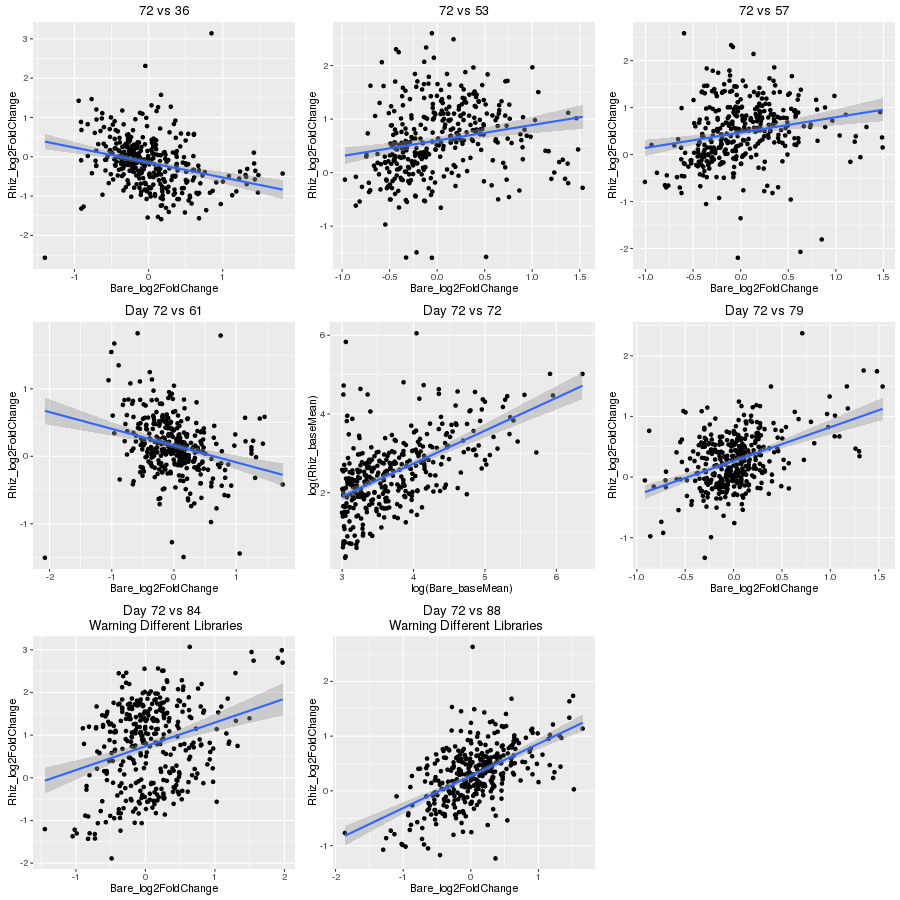

In [129]:
%%R -w 900 -h 900
grid.arrange(p.36, p.53, p.57, p.61, p.72, p.79, p.84, p.88, ncol = 3)